# **World Model – Rollouts Generation**


**This notebook focuses on generating datasets consisting of environment observations (images) and actions to train the Vision Model (VAE) and Memory Model (LSTM-MDN) as part of the World Model framework.**



### **Environment - CarRacing-v3**
---
The [CarRacing-v3](https://gymnasium.farama.org/environments/box2d/car_racing/)
environment from Gymnasium provides a challenging reinforcement learning task where the agent must navigate a race track.

<img src="imgs/CarRacing.gif" alt="CarRacing Game" width="500" style="border-radius: 25px;"/>

#### **Environment Details**
Each time the environment resets, a procedurally generated race track is created. The complexity varies significantly - from simple tracks with gentle curves to complex circuits with numerous tight 180° turns.

**Continuous Action Space:**
- Steering: [-1, 1] (negative: left, positive: right)
- Acceleration: [0, 1] (higher values increase speed)
- Braking: [0, 1] (higher values increase braking force)

**Reward Structure:**
Each episode lasts for 1000 time steps maximum
A constant penalty of -0.1 is applied at each time step
The track is divided into tiles; driving over a tile provides +1000/N reward (where N is the total number of tiles)
For example, completing a track (passing over all tiles) in 732 steps would yield a total reward of: 1000 - (0.1 × 732) = 926.8

### **Image Processing**
---

The **CarRacing-v3** environment provides observations with a resolution of ```(96×96×3)```. We'll maintain the resolution of ```(96×96×3)``` but crop the game information display from the bottom.

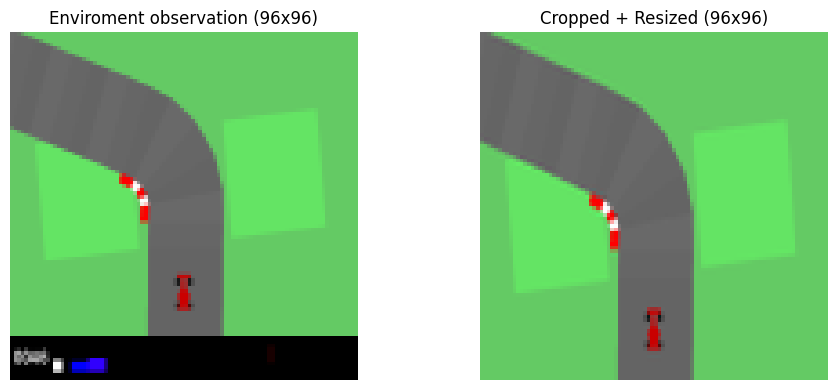

In [1]:
import gymnasium as gym
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

env = gym.make('CarRacing-v3', render_mode="rgb_array")
env.reset()
for _ in range(70):
    obs, reward, done, truncated, info = env.step(np.array([0,1,0]))

obs_cropped = obs[:-12, :, :]
obs_cropped = Image.fromarray(obs_cropped)
obs_resized = obs_cropped.resize((96,96), Image.Resampling.LANCZOS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(obs)
axs[0].set_title('Enviroment observation (96x96)')
axs[0].axis('off')

axs[1].imshow(obs_resized)
axs[1].set_title('Cropped + Resized (96x96)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

### **Pseudo-Random Action Strategy**
--- 

Using purely random actions creates a significant data collection issue. Random actions typically cause the car to spin out of control and drive off the track, resulting in an unbalanced dataset with few useful driving examples. This would lead to:

- Poor reconstruction of crucial features like sharp turns
- Inconsistent road distribution in the latent space
- Insufficient examples for the model to learn proper driving behavior

To address this, we use a pseudo-random action strategy with the following distribution:

| Acción         | Valores               | Probabilidad     |
|----------------|-----------------------|-------------------|
| Accelerate    | [0, random, 0]       | 35%               |
| Turn Left     | [-random, 0, 0]      | 30%               |
| Turn Right	| [+random, 0, 0]      | 30%               |
| Brake         | [0, 0, random]       | 5%               |

Where "random" is a value between 0 and 1

In [2]:
import numpy as np

def random_action(t):
    """
    Generate pseudo-random actions based on the current time step (t).
    
    Args:
        t: Current time step in the episode
        
    Returns:
        numpy.ndarray: Action vector [steering, acceleration, brake]
    """
    if t < 20:
        return np.array([-.1, 1, 0])

    actions = [
        np.array([0, np.random.random(), 0]),    # Random Accelerate
        np.array([-np.random.random(), 0, 0]),   # Random Turn Left
        np.array([np.random.random(), 0, 0]),    # Random Turn Right
        np.array([0, 0, np.random.random()]),    # Random Brake
    ]
    probabilities = [.35, .3, .3, .05]  # Probabilities for each action

    # Select a random action based on the defined probabilities
    selected_action = np.random.choice(len(actions), p=probabilities)
    return actions[selected_action]


## **Efficient Data Collection and Storage**
---

To optimize the process of generating a large dataset (e.g., 10.000 episodes), we utilize [HDF5](https://docs.h5py.org/en/stable/) for efficient data storage and parallel processing for data collection.

### Data Collection Strategy

1. **Parallelization**: The workload is distributed across available CPU cores, with each worker handling a portion of the episodes.
2. **Intermediate Storage**: Each worker generates episodes and stores them in temporary HDF5 files.
3. **Dataset Consolidation**: After all episodes are generated, the temporary files are merged into a single HDF5 dataset.
4. **Episode Handling**: If the car goes off-track before completing the 1000 steps, the environment is reset and the episode continues until the full length is reached.

### Final Dataset Structure

<img src='imgs/HDF5.png' width=800>

```
root:
  actions = float32(num_episodes x 1000 x 3)
  dones   =    bool(num_episodes x 1000)
  images  =   uint8(num_episodes x 1000 x 96 x 96 x 3)
  rewards = float32(num_episodes x 1000)
```

In [ ]:
import gymnasium as gym
import numpy as np
import h5py
from multiprocessing import Pool, cpu_count
from PIL import Image
import gc 
import os

def resize_obs(image, target_size=(96, 96)):
    """
    Crop the observation image and resize it to target_size.
    
    Args:
        image: Raw observation image from environment
        target_size: Desired output dimensions as (width, height)
        
    Returns:
        numpy.ndarray: Processed image
    """
    image_cropped = image[:-12, :, :]  # Remove bottom info bar
    img = Image.fromarray(image_cropped)
    img = img.resize(target_size, Image.Resampling.LANCZOS)  # High-quality downsampling
    return np.array(img)


def collect_episode(env_name, max_steps, episode_id, worker_id, output_dir):
    """
    Collect data for a single episode and write it to an HDF5 file.
    
    Args:
        env_name (str): The Gym environment identifier
        max_steps (int): Maximum number of steps per episode
        episode_id (int): The episode's unique identifier
        worker_id (int): The worker's unique identifier
        output_dir (str): Directory to store episode files
    """
    # Initialize lists to store episode data
    episode_images = []
    episode_actions = []
    episode_rewards = []
    episode_dones = []
    
    env = gym.make(env_name, render_mode='rgb_array')
    obs, _ = env.reset()

    for step in range(max_steps):
        # Process and store the observation
        resized_image = resize_obs(obs)
        episode_images.append(resized_image)

        # Generate action (new pseudo-random action every 20 steps)
        if step % 20 == 0:
            action = random_action(step)
        episode_actions.append(action)

        # Execute action and store results
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards.append(reward)
        episode_dones.append(done)

        # Reset if episode terminates early
        if done:
            obs, _ = env.reset()

    # Convert lists to NumPy arrays
    episode_images = np.array(episode_images, dtype=np.uint8)
    episode_actions = np.array(episode_actions, dtype=np.float32)
    episode_rewards = np.array(episode_rewards, dtype=np.float32)
    episode_dones = np.array(episode_dones, dtype=bool)

    # Define the episode file path
    episode_filename = f'worker_{worker_id}_episode_{episode_id}.h5'
    episode_path = os.path.join(output_dir, episode_filename)

    # Write the episode data to an HDF5 file
    with h5py.File(episode_path, 'w') as h5f:
        h5f.create_dataset('images', data=episode_images, dtype='uint8')
        h5f.create_dataset('actions', data=episode_actions, dtype='float32')
        h5f.create_dataset('rewards', data=episode_rewards, dtype='float32')
        h5f.create_dataset('dones', data=episode_dones, dtype='bool')

    # Clean up memory
    env.close()
    del episode_images, episode_actions, episode_rewards, episode_dones
    del resized_image, action, reward, done, truncated, info, obs, env
    gc.collect()  # Explicitly trigger garbage collection
    

def collect_data_worker(args):
    """
    Worker function to collect multiple episodes and write each to a separate file.
    
    Args:
        args: Tuple containing (env_name, num_episodes, max_steps, output_dir, worker_id)
    """
    env_name, num_episodes, max_steps, output_dir, worker_id = args

    for ep in range(num_episodes):
        collect_episode(env_name, max_steps, ep, worker_id, output_dir)
        print(f"Worker {worker_id}: Episode ({ep+1}/{num_episodes}) completed")

    print(f"Worker {worker_id}: Completed {num_episodes} episodes.")


def collect_data(env_name='CarRacing-v3', num_episodes=100, max_steps=1000, 
                output_dir='episodes_data', num_workers=None):
    """
    Collect data from the environment and store each episode in a separate HDF5 file.
    
    Args:
        env_name (str): Name of the Gym environment
        num_episodes (int): Total number of episodes to generate
        max_steps (int): Maximum steps per episode
        output_dir (str): Directory to store episode files
        num_workers (int, optional): Number of worker processes. Defaults to CPU count
    """
    if num_workers is None:
        num_workers = cpu_count()-1 # Use all available CPU cores

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Determine episodes per worker
    episodes_per_worker = num_episodes // num_workers
    remaining_episodes = num_episodes % num_workers

    # Prepare arguments for each worker
    worker_args = []
    for i in range(num_workers):
        worker_episodes = episodes_per_worker + (1 if i < remaining_episodes else 0)
        args = (env_name, worker_episodes, max_steps, output_dir, i)
        worker_args.append(args)

    # Use Pool for multiprocessing with controlled number of workers
    with Pool(processes=num_workers) as pool:
        list(pool.imap_unordered(collect_data_worker, worker_args))

    print("Data collection completed.")

In [4]:
%%time
collect_data(env_name='CarRacing-v3', num_episodes=128, max_steps=1000, output_dir='temp_episodes_data')

Worker 10: Episode (1/8) completed
Worker 1: Episode (1/8) completed
Worker 3: Episode (1/8) completed
Worker 15: Episode (1/8) completed
Worker 9: Episode (1/8) completed
Worker 5: Episode (1/8) completed
Worker 13: Episode (1/8) completed
Worker 7: Episode (1/8) completed
Worker 11: Episode (1/8) completed
Worker 12: Episode (1/8) completed
Worker 6: Episode (1/8) completed
Worker 8: Episode (1/8) completed
Worker 0: Episode (1/8) completed
Worker 14: Episode (1/8) completed
Worker 4: Episode (1/8) completed
Worker 2: Episode (1/8) completed
Worker 3: Episode (2/8) completed
Worker 5: Episode (2/8) completed
Worker 4: Episode (2/8) completed
Worker 15: Episode (2/8) completed
Worker 13: Episode (2/8) completed
Worker 11: Episode (2/8) completed
Worker 7: Episode (2/8) completed
Worker 8: Episode (2/8) completed
Worker 10: Episode (2/8) completed
Worker 9: Episode (2/8) completed
Worker 6: Episode (2/8) completed
Worker 0: Episode (2/8) completed
Worker 14: Episode (2/8) completed
Wor

### **Consolidating Episodes into a Single Dataset**
After collecting individual episode data files, we need to merge them into a unified dataset structure for efficient training access.

In [5]:
import os
import h5py
from tqdm import tqdm

def merge_episode_files(episodes_dir='temp_episodes_data',
                        output_file='merged_data.h5', 
                        env_name='CarRacing-v3',
                        num_max_steps=1000):
    """
    Merge multiple episode HDF5 files into a single HDF5 dataset.
    
    Args:
        episodes_dir (str): Directory containing individual episode files
        output_file (str): Path for the consolidated output file
        env_name (str): Environment name (for documentation purposes)
        num_max_steps (int): Expected number of steps per episode
    """
    # Step 1: Locate all episode files
    episode_files = [
        os.path.join(episodes_dir, f)
        for f in os.listdir(episodes_dir)
        if f.endswith('.h5') or f.endswith('.hdf5')
    ]

    num_episodes = len(episode_files)
    if num_episodes == 0:
        raise ValueError(f"No HDF5 episode files found in directory: {episodes_dir}")

    print(f"Found {num_episodes} episode files in '{episodes_dir}'.")

    # Optional: Sort files for consistent ordering
    episode_files.sort()

    # Step 2: Verify episode integrity
    for file in episode_files:
        with h5py.File(file, 'r') as h5f:
            actions_shape = h5f['actions'].shape
            if actions_shape[0] != num_max_steps:
                raise ValueError(
                    f"Episode file {file} has {actions_shape[0]} steps, expected {num_max_steps}."
                )

    # Step 3: Initialize the merged HDF5 file
    with h5py.File(output_file, 'w') as merged_h5f:
        # Initialize datasets with optimized chunking
        actions_shape = (num_episodes, num_max_steps, 3)
        dones_shape = (num_episodes, num_max_steps)
        images_shape = (num_episodes, num_max_steps, 96, 96, 3)
        rewards_shape = (num_episodes, num_max_steps)

        print("Initializing datasets in the merged HDF5 file...")
        merged_h5f.create_dataset('actions', shape=actions_shape,
                                 dtype='float16', chunks=(1, num_max_steps, 3))
        merged_h5f.create_dataset('dones', shape=dones_shape,
                                 dtype='bool', chunks=(1, num_max_steps))
        merged_h5f.create_dataset('images', shape=images_shape,
                                 dtype='uint8', chunks=(1, num_max_steps, 96, 96, 3))
        merged_h5f.create_dataset('rewards', shape=rewards_shape,
                                 dtype='int', chunks=(1, num_max_steps))

        # Step 4: Iterate through each episode and write to the merged file
        for idx, episode_file in enumerate(tqdm(episode_files, desc="Merging Episodes")):
            with h5py.File(episode_file, 'r') as ep_h5f:
                # Read datasets from the episode file
                actions = ep_h5f['actions'][:]
                dones = ep_h5f['dones'][:]
                images = ep_h5f['images'][:]
                rewards = ep_h5f['rewards'][:]

                # Write to the merged datasets
                merged_h5f['actions'][idx, :, :] = actions
                merged_h5f['dones'][idx, :] = dones
                merged_h5f['images'][idx, :, :, :, :] = images
                merged_h5f['rewards'][idx, :] = rewards

            # Step 5: Clean up temporary files
            try:
                os.remove(episode_file)
            except Exception as de:
                print(f"Error deleting temporary file '{episode_file}': {de}")

    print(f"Merging completed successfully. Merged data saved to '{output_file}'.")


# Merge the previously generated episode files
merge_episode_files(episodes_dir='temp_episodes_data', 
                   output_file='car_racing_data_128.h5', 
                   env_name='CarRacing-v3', 
                   num_max_steps=1000)

Found 128 episode files in 'temp_episodes_data'.
Initializing datasets in the merged HDF5 file...


Merging Episodes: 100%|██████████| 128/128 [00:05<00:00, 22.13it/s]


Merging completed successfully. Merged data saved to 'car_racing_data_128.h5'.


In [6]:
import nexusformat.nexus as nx

# Verify dataset structure
f = nx.nxload('car_racing_data_128.h5')
print(f.tree)

root:NXroot
  actions = float16(128x1000x3)
  dones = bool(128x1000)
  images = uint8(128x1000x96x96x3)
  rewards = int64(128x1000)


### **Creating a PyTorch Dataset**
To efficiently use our collected data for model training, we'll implement a custom PyTorch Dataset that provides streaming access to the HDF5 file.



In [7]:
import h5py
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CarRacingDataset(Dataset):
    """
    PyTorch Dataset for CarRacing data stored in HDF5 format.
    
    This dataset provides on-demand access to observations, actions, rewards,
    and done flags stored in the consolidated HDF5 file.
    """
    
    def __init__(self, h5_path='car_racing_data.h5', transform=None):
        """
        Initialize the dataset.
        
        Args:
            h5_path (str): Path to the HDF5 file containing the dataset
            transform (callable, optional): Transform to apply to the observations
        """
        self.h5_path = h5_path
        
        self.transform = transform if transform is not None else transforms.ToTensor()
        
        # Open the HDF5 file to retrieve dataset dimensions
        with h5py.File(self.h5_path, 'r') as h5f:
            self.num_episodes, self.max_steps = h5f['images'].shape[:2]
            self.total_frames = self.num_episodes * self.max_steps
    
        self.h5_file = None  # Will be opened on first access
    
    def __len__(self):
        """Return the total number of frames in the dataset."""
        return self.total_frames
    
    def __getitem__(self, idx):
        """
        Retrieve a single frame and associated data.
        
        Args:
            idx (int): Index of the frame to retrieve
            
        Returns:
            tuple: (image, action, reward, done) tensors
        """
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
        
        # Calculate episode and step from the flat index
        episode = idx // self.max_steps
        step = idx % self.max_steps
        
        # Access the datasets directly using episode and step indices
        image = self.h5_file['images'][episode, step]       
        action = self.h5_file['actions'][episode, step]      
        reward = self.h5_file['rewards'][episode, step]     
        done = self.h5_file['dones'][episode, step]          
        
        # Apply the transform (e.g., ToTensor)
        image = self.transform(image)  # Converts to [C, H, W] and scales to [0, 1]
        
        # Convert action, reward, and done to tensors
        action = torch.tensor(action, dtype=torch.float32)  
        reward = torch.tensor(reward, dtype=torch.float32)  
        done = torch.tensor(done, dtype=torch.float32)     
        
        return image, action, reward, done
    
    def __del__(self):
        """Ensure the HDF5 file is closed when the dataset is deleted."""
        if self.h5_file is not None:
            self.h5_file.close()

### **Visualizing the Dataset**

This allows us to inspect the images in sequence, ensuring they're properly stored and aligned with their respective episode and step information.

In [8]:
import pygame
from torch.utils.data import DataLoader
import numpy as np

def display_dataset(dataloader, scale=1):
    """
    Visualize the dataset using Pygame.
    
    Args:
        dataloader: PyTorch DataLoader containing the dataset
        scale (int): Scale factor for display window
    """
    pygame.init()
    pygame.font.init()

    # Configure pygame window
    image_size = 96
    window_size = (int(image_size * scale), int(image_size * scale))
    screen = pygame.display.set_mode(window_size)
    pygame.display.set_caption('Dataset Visualizer')
    clock = pygame.time.Clock()  

    rollout_id = 0
    step = 0

    for images, actions, rewards, dones in dataloader:
        # Process the image for display
        images = images.squeeze(0).permute(2, 1, 0).cpu().numpy()  
        images = (images * 255).astype(np.uint8)  
        images = pygame.surfarray.make_surface(images)
        images = pygame.transform.scale(images, window_size)  

        # Draw the image to screen
        screen.blit(images, (0, 0))

        # Add rollout and step information overlay
        font = pygame.font.SysFont(None, 24)
        text = font.render(f'Rollout: {rollout_id} Step: {step}', True, (255, 255, 255))
        screen.blit(text, (10, 10))

        pygame.display.update()

        # Control playback speed
        clock.tick(60)  # 60 FPS
        
        # Update step/episode counters
        step += 1
        if step == 1000:  # End of episode
            step = 0
            rollout_id += 1

        # Check for exit command
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return

    pygame.quit()

# Create dataset and dataloader
dataset = CarRacingDataset('car_racing_data_128.h5')
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Launch the visualizer
display_dataset(dataloader, scale=4)